# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

# Problem 3

- Keep MNIST (handwritten digits) dataset. Work with the DCGAN with the Discriminator and the Generator defined in cell 12.
- This network will be much slower to train than the network used in Problem 1. Unless you have a powerful GPU card on your local machine, run this training in Google Colab.
- If working in Google Colab do not use MLflow API to instrument your code.
- Add your routine for the quantitative assessment of the quality of generated images.
- Add a cell that would report on the Generator and the Discriminator loss and two outputs of the Discriminator.
- Test whether your code works with a small number of epochs before making a 100 epoch run.
- Report on the improvements or decrease of quality in network behavior and the quality of generated images.
- Make the comparison of losses of the discriminator and the generator with those obtained in the network used in Problem 1

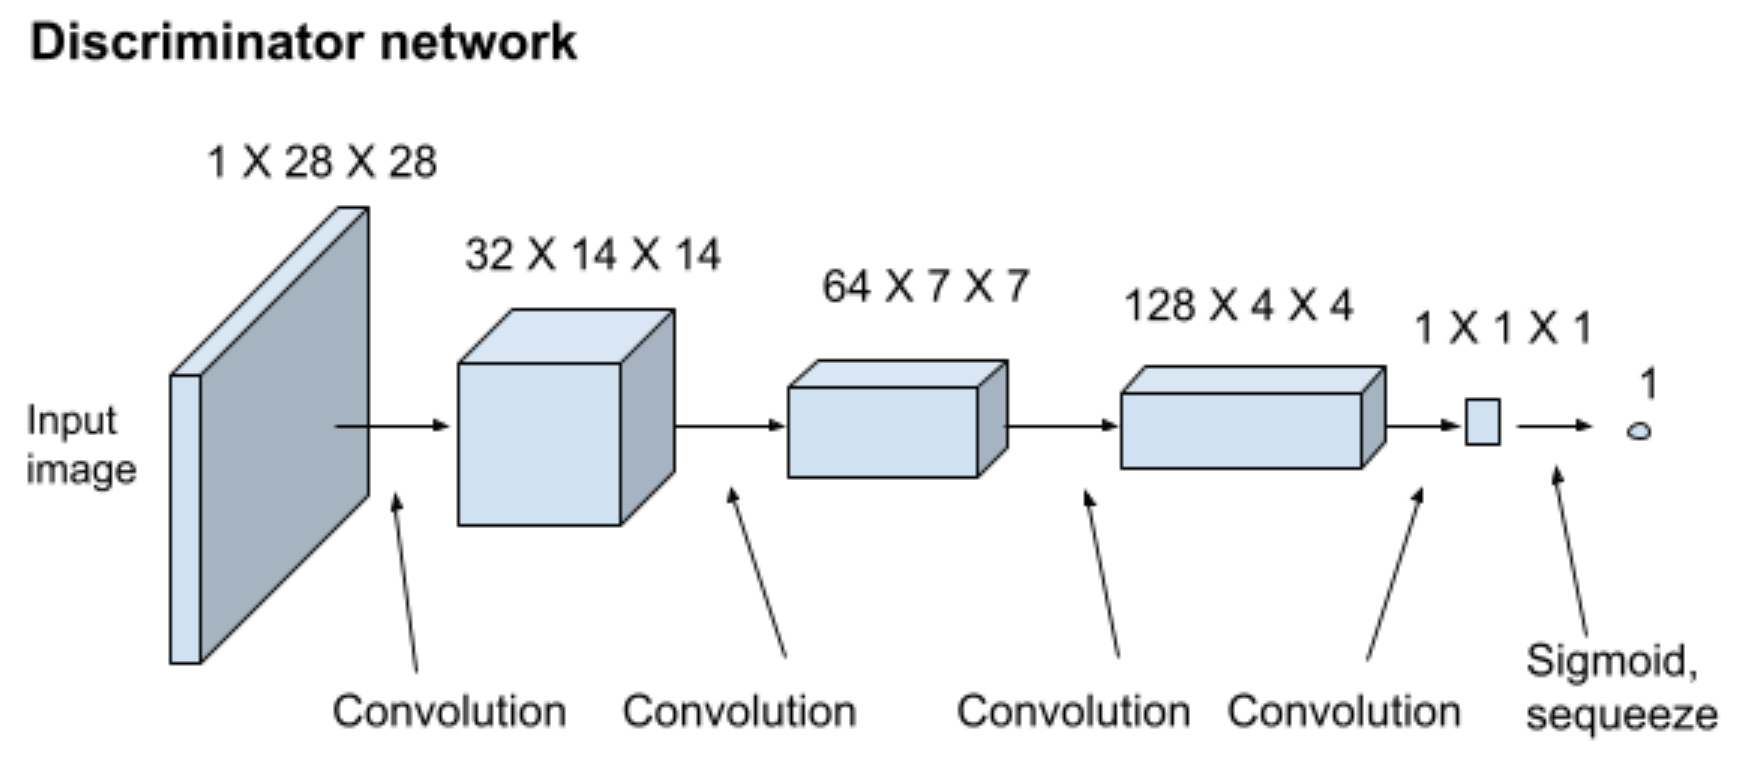

In [ ]:
Image(filename='figures/17_13.png', width=700)

 * **Setting up the Google Colab**

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [27]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.1.0+cu121
GPU Available: True


In [28]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Train the DCGAN model

In [29]:
import torchvision
from torchvision import transforms


image_path = '/content/drive/MyDrive/Colab Notebooks'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=False)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)


In [30]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)


In [31]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [32]:
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)


In [33]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [34]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


In [35]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()


In [36]:
import math


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1).to(device)
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1).to(device)
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX,nY) + Y2.expand(nY,nX).transpose(0,1) - 2*torch.mm(X,Y.transpose(0,1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M+M.abs())/2).sqrt()

    return M

In [37]:
def mmd(Mxx, Mxy, Myy, sigma) :
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx/(scale*2*sigma*sigma))
    Mxy = torch.exp(-Mxy/(scale*2*sigma*sigma))
    Myy = torch.exp(-Myy/(scale*2*sigma*sigma))
    a = Mxx.mean()+Myy.mean()-2*Mxy.mean()
    mmd = math.sqrt(max(a, 0))

    return mmd

In [38]:
def compute_score(fake, real , k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)


    return(mmd(Mxx, Mxy, Myy, sigma))

In [39]:
batch_size = 64
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        batch_size = x.size(0)
        real = x.view(batch_size, -1).to(device)


    d_proba_real_cpu = d_proba_real.cpu()
    d_proba_fake_cpu = d_proba_fake.cpu()


    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}'
          f' D_Real {torch.FloatTensor(d_proba_real_cpu).mean():.4f}'
          f' D_Fake {torch.FloatTensor(d_proba_fake_cpu).mean():.4f}')


    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())


    samples = create_samples(gen_model, fixed_z).detach().cpu().numpy()
    epoch_samples.append(samples)
    fake = create_samples(gen_model, fixed_z).detach()

    score = compute_score(fake, real, k=1, sigma=1, sqrt=True)
    print("MMD score", score)

KeyboardInterrupt: 

Output from above cell:

Epoch 001 | Avg Losses >> G/D 2.7816/0.3364 D_Real 0.9274 D_Fake 0.1669
MMD score 0.9118061092465739
Epoch 002 | Avg Losses >> G/D 2.8786/0.3271 D_Real 0.9603 D_Fake 0.1314
MMD score 0.8981302150503235
Epoch 003 | Avg Losses >> G/D 2.9880/0.3035 D_Real 0.9201 D_Fake 0.0755
MMD score 0.8990704172983771
Epoch 004 | Avg Losses >> G/D 3.0286/0.3225 D_Real 0.9682 D_Fake 0.0957
MMD score 0.9043812722685247
Epoch 005 | Avg Losses >> G/D 2.9550/0.2895 D_Real 0.8752 D_Fake 0.0239
MMD score 0.8642006375641293
Epoch 006 | Avg Losses >> G/D 3.0381/0.2735 D_Real 0.9602 D_Fake 0.0936
MMD score 0.8823419515308705
Epoch 007 | Avg Losses >> G/D 3.0754/0.2891 D_Real 0.9370 D_Fake 0.0399
MMD score 0.8794610201171263
Epoch 008 | Avg Losses >> G/D 3.0769/0.3036 D_Real 0.9434 D_Fake 0.1442
MMD score 0.908475117306442
Epoch 009 | Avg Losses >> G/D 3.1367/0.2638 D_Real 0.9043 D_Fake 0.1405
MMD score 0.9195435995538264
Epoch 010 | Avg Losses >> G/D 3.1970/0.3037 D_Real 0.9745 D_Fake 0.1705
MMD score 0.8903617135100498
Epoch 011 | Avg Losses >> G/D 3.1502/0.2762 D_Real 0.8010 D_Fake 0.1436
MMD score 0.8481901394841846
Epoch 012 | Avg Losses >> G/D 3.2788/0.2393 D_Real 0.9475 D_Fake 0.0330
MMD score 0.908232067016166
Epoch 013 | Avg Losses >> G/D 3.2422/0.2531 D_Real 0.9547 D_Fake 0.0482
MMD score 0.9062023150296382
Epoch 014 | Avg Losses >> G/D 3.3499/0.2446 D_Real 0.9944 D_Fake 0.0581
MMD score 0.867158665907966
Epoch 015 | Avg Losses >> G/D 3.4582/0.2223 D_Real 0.8989 D_Fake 0.0064
MMD score 0.8826321442956062
Epoch 016 | Avg Losses >> G/D 3.3881/0.2502 D_Real 0.9893 D_Fake 0.2336
MMD score 0.8956534330722303
Epoch 017 | Avg Losses >> G/D 3.4911/0.2267 D_Real 0.9533 D_Fake 0.1447
MMD score 0.8822899681414244
Epoch 018 | Avg Losses >> G/D 3.5637/0.2193 D_Real 0.9640 D_Fake 0.0325
MMD score 0.8936826520500585
Epoch 019 | Avg Losses >> G/D 3.5796/0.2210 D_Real 0.8385 D_Fake 0.0569
MMD score 0.9133720072217864
Epoch 020 | Avg Losses >> G/D 3.5350/0.2337 D_Real 0.9183 D_Fake 0.0688
MMD score 0.8989800846537508
Epoch 021 | Avg Losses >> G/D 3.6294/0.2120 D_Real 0.8832 D_Fake 0.0791
MMD score 0.9146801092841688
Epoch 022 | Avg Losses >> G/D 3.7343/0.2036 D_Real 0.9787 D_Fake 0.1360
MMD score 0.8738578426404876
Epoch 023 | Avg Losses >> G/D 3.6948/0.2007 D_Real 0.9746 D_Fake 0.0254
MMD score 0.8688510712484344
Epoch 024 | Avg Losses >> G/D 3.7153/0.1921 D_Real 0.9490 D_Fake 0.0370
MMD score 0.9046697321647519
Epoch 025 | Avg Losses >> G/D 3.8622/0.1915 D_Real 0.9823 D_Fake 0.1542
MMD score 0.8964177192059325
Epoch 026 | Avg Losses >> G/D 3.7491/0.2171 D_Real 0.9416 D_Fake 0.0759
MMD score 0.8553540226896212
Epoch 027 | Avg Losses >> G/D 3.8533/0.1840 D_Real 0.9762 D_Fake 0.0185
MMD score 0.8903512701374565
Epoch 028 | Avg Losses >> G/D 3.9587/0.1674 D_Real 0.9591 D_Fake 0.0690
MMD score 0.8752954869658109
Epoch 029 | Avg Losses >> G/D 3.8192/0.2202 D_Real 0.9861 D_Fake 0.3921
MMD score 0.9084392937851482
Epoch 030 | Avg Losses >> G/D 4.0057/0.1573 D_Real 0.9667 D_Fake 0.0047
MMD score 0.887957241581854
Epoch 031 | Avg Losses >> G/D 4.0091/0.1855 D_Real 0.9968 D_Fake 0.0242
MMD score 0.8965700727736631
Epoch 032 | Avg Losses >> G/D 4.0801/0.1761 D_Real 0.9729 D_Fake 0.0426
MMD score 0.8787382516306236
Epoch 033 | Avg Losses >> G/D 3.9961/0.1819 D_Real 0.9987 D_Fake 0.1078
MMD score 0.8779563348139794
Epoch 034 | Avg Losses >> G/D 4.0537/0.1655 D_Real 0.9931 D_Fake 0.0419
MMD score 0.8877480872049568
Epoch 035 | Avg Losses >> G/D 4.1474/0.1760 D_Real 0.7164 D_Fake 0.0150
MMD score 0.9107663970484834
Epoch 036 | Avg Losses >> G/D 4.0798/0.1697 D_Real 0.9255 D_Fake 0.0839
MMD score 0.8962568937752097
Epoch 037 | Avg Losses >> G/D 4.1996/0.1607 D_Real 0.9982 D_Fake 0.2503
MMD score 0.8969891026982125
Epoch 038 | Avg Losses >> G/D 4.2152/0.1420 D_Real 0.9623 D_Fake 0.0627
MMD score 0.873990055064748
Epoch 039 | Avg Losses >> G/D 4.3440/0.1530 D_Real 0.9835 D_Fake 0.0424
MMD score 0.9001449613917819
Epoch 040 | Avg Losses >> G/D 4.3362/0.1799 D_Real 0.8520 D_Fake 0.0509
MMD score 0.8840552503464535
Epoch 041 | Avg Losses >> G/D 4.3206/0.1345 D_Real 0.9863 D_Fake 0.0973
MMD score 0.8818034253722481
Epoch 042 | Avg Losses >> G/D 4.3029/0.1715 D_Real 0.8410 D_Fake 0.0050
MMD score 0.8785538030311841
Epoch 043 | Avg Losses >> G/D 4.4119/0.1367 D_Real 0.9174 D_Fake 0.0169
MMD score 0.8840215050640513
Epoch 044 | Avg Losses >> G/D 4.3591/0.1584 D_Real 0.8374 D_Fake 0.0091
MMD score 0.884020830819509
Epoch 045 | Avg Losses >> G/D 4.3266/0.1762 D_Real 0.9960 D_Fake 0.0266
MMD score 0.8786040061909712
Epoch 046 | Avg Losses >> G/D 4.3864/0.1300 D_Real 0.9693 D_Fake 0.0352
MMD score 0.8869781786826711
Epoch 047 | Avg Losses >> G/D 4.4400/0.1544 D_Real 0.9875 D_Fake 0.0390
MMD score 0.8947368868548793
Epoch 048 | Avg Losses >> G/D 4.5555/0.1421 D_Real 0.9763 D_Fake 0.0539
MMD score 0.8841931172895783
Epoch 049 | Avg Losses >> G/D 4.5652/0.1224 D_Real 0.9693 D_Fake 0.0449
MMD score 0.8766907297271939
Epoch 050 | Avg Losses >> G/D 4.6882/0.1489 D_Real 0.6422 D_Fake 0.0051
MMD score 0.9083884101466796
Epoch 051 | Avg Losses >> G/D 4.4407/0.1419 D_Real 0.9584 D_Fake 0.0131
MMD score 0.874072434740885
Epoch 052 | Avg Losses >> G/D 4.5643/0.1269 D_Real 0.9979 D_Fake 0.0745
MMD score 0.8960882903434104
Epoch 053 | Avg Losses >> G/D 4.7627/0.0959 D_Real 0.9617 D_Fake 0.0200
MMD score 0.8872830112235444
Epoch 054 | Avg Losses >> G/D 4.6721/0.1324 D_Real 0.9893 D_Fake 0.0023
MMD score 0.908271704924989
Epoch 055 | Avg Losses >> G/D 4.7287/0.1436 D_Real 0.9189 D_Fake 0.0597
MMD score 0.8931543672937606
Epoch 056 | Avg Losses >> G/D 4.8055/0.0900 D_Real 0.6045 D_Fake 0.0017
MMD score 0.8857997888175073
Epoch 057 | Avg Losses >> G/D 4.8110/0.1204 D_Real 0.9802 D_Fake 0.0397
MMD score 0.8727691003681174
Epoch 058 | Avg Losses >> G/D 4.7287/0.1230 D_Real 0.9879 D_Fake 0.0601
MMD score 0.9021909510061223
Epoch 059 | Avg Losses >> G/D 4.8137/0.1517 D_Real 0.9648 D_Fake 0.0109
MMD score 0.8750199588134195
Epoch 060 | Avg Losses >> G/D 4.7453/0.1077 D_Real 0.9437 D_Fake 0.0139
MMD score 0.8858865874662858
Epoch 061 | Avg Losses >> G/D 4.9052/0.1001 D_Real 0.9328 D_Fake 0.0189
MMD score 0.9056141036426563
Epoch 062 | Avg Losses >> G/D 4.7949/0.1530 D_Real 0.9714 D_Fake 0.0009
MMD score 0.9065129457676094
Epoch 063 | Avg Losses >> G/D 4.8861/0.1106 D_Real 0.9780 D_Fake 0.0037
MMD score 0.8828557096726296
Epoch 064 | Avg Losses >> G/D 4.7605/0.1254 D_Real 0.9972 D_Fake 0.0276
MMD score 0.8903211778115406
Epoch 065 | Avg Losses >> G/D 4.9296/0.1066 D_Real 0.9637 D_Fake 0.0041
MMD score 0.9018609542968998
Epoch 066 | Avg Losses >> G/D 4.9723/0.1096 D_Real 0.9986 D_Fake 0.0766
MMD score 0.8934056225453931
Epoch 067 | Avg Losses >> G/D 4.9757/0.1051 D_Real 0.9680 D_Fake 0.0131
MMD score 0.8947296588863279
Epoch 068 | Avg Losses >> G/D 5.0713/0.0909 D_Real 0.7875 D_Fake 0.0015
MMD score 0.8866699474197536
Epoch 069 | Avg Losses >> G/D 4.7259/0.1702 D_Real 0.9963 D_Fake 0.0205
MMD score 0.8991033657361008
Epoch 070 | Avg Losses >> G/D 5.0925/0.1338 D_Real 0.9128 D_Fake 0.0648
MMD score 0.8937854239639532
Epoch 071 | Avg Losses >> G/D 4.7381/0.1123 D_Real 0.9908 D_Fake 0.0655
MMD score 0.9002994648427707
Epoch 072 | Avg Losses >> G/D 4.9339/0.1036 D_Real 0.9925 D_Fake 0.0102
MMD score 0.8761912819511152
Epoch 073 | Avg Losses >> G/D 4.9578/0.1118 D_Real 0.9296 D_Fake 0.0040
MMD score 0.8742970299467103
Epoch 074 | Avg Losses >> G/D 5.0486/0.1166 D_Real 0.9892 D_Fake 0.0259
MMD score 0.9002223323012224
Epoch 075 | Avg Losses >> G/D 5.1169/0.1006 D_Real 0.9551 D_Fake 0.0382
MMD score 0.8873663734525064
Epoch 076 | Avg Losses >> G/D 5.0422/0.1197 D_Real 0.9886 D_Fake 0.0064
MMD score 0.8937377075203609
Epoch 077 | Avg Losses >> G/D 5.1245/0.0978 D_Real 0.9985 D_Fake 0.3072
MMD score 0.8912384530559349
Epoch 078 | Avg Losses >> G/D 5.0504/0.1219 D_Real 0.9883 D_Fake 0.0247
MMD score 0.8956824811443848
Epoch 079 | Avg Losses >> G/D 5.0055/0.1205 D_Real 0.9984 D_Fake 0.2268
MMD score 0.8878671544837538
Epoch 080 | Avg Losses >> G/D 5.0761/0.0896 D_Real 0.9969 D_Fake 0.0057
MMD score 0.8861699695797042
Epoch 081 | Avg Losses >> G/D 5.1272/0.0929 D_Real 0.9592 D_Fake 0.0291
MMD score 0.8967573627055877
Epoch 082 | Avg Losses >> G/D 5.1852/0.0995 D_Real 0.4121 D_Fake 0.0016
MMD score 0.8959587733840328
Epoch 083 | Avg Losses >> G/D 5.0877/0.1126 D_Real 0.9858 D_Fake 0.0216
MMD score 0.8768301624844279
Epoch 084 | Avg Losses >> G/D 5.0842/0.0879 D_Real 0.9883 D_Fake 0.0442
MMD score 0.8887826368453137
Epoch 085 | Avg Losses >> G/D 5.0162/0.1338 D_Real 0.9984 D_Fake 0.0018
MMD score 0.8814252909020551
Epoch 086 | Avg Losses >> G/D 5.0665/0.1171 D_Real 0.9916 D_Fake 0.0289
MMD score 0.8793976829764628
Epoch 087 | Avg Losses >> G/D 4.9655/0.1383 D_Real 0.9947 D_Fake 0.0656
MMD score 0.8878217382598248
Epoch 088 | Avg Losses >> G/D 5.3246/0.0749 D_Real 0.9999 D_Fake 0.1044
MMD score 0.8905967239442131
Epoch 089 | Avg Losses >> G/D 5.1235/0.1201 D_Real 0.9824 D_Fake 0.0077
MMD score 0.9054926305457299
Epoch 090 | Avg Losses >> G/D 5.2308/0.0823 D_Real 0.9975 D_Fake 0.0089
MMD score 0.8767182645250797
Epoch 091 | Avg Losses >> G/D 5.3337/0.0718 D_Real 0.9959 D_Fake 0.2751
MMD score 0.8958861572009449
Epoch 092 | Avg Losses >> G/D 4.9743/0.1393 D_Real 0.9974 D_Fake 0.2237
MMD score 0.8721269715155502
Epoch 093 | Avg Losses >> G/D 5.3066/0.0752 D_Real 0.9947 D_Fake 0.0299
MMD score 0.9052558247026702
Epoch 094 | Avg Losses >> G/D 5.0886/0.1201 D_Real 0.9948 D_Fake 0.0464
MMD score 0.8649538847036178
Epoch 095 | Avg Losses >> G/D 5.2650/0.0881 D_Real 0.9937 D_Fake 0.2067
MMD score 0.9033534688277324
Epoch 096 | Avg Losses >> G/D 5.1481/0.1255 D_Real 0.9171 D_Fake 0.0001
MMD score 0.9010572634249309
Epoch 097 | Avg Losses >> G/D 5.2663/0.1071 D_Real 0.6655 D_Fake 0.0003
MMD score 0.8753575207682269
Epoch 098 | Avg Losses >> G/D 5.2788/0.0830 D_Real 0.9994 D_Fake 0.0242
MMD score 0.8556546919291529
Epoch 099 | Avg Losses >> G/D 5.3987/0.0736 D_Real 0.9982 D_Fake 0.0552
MMD score 0.877040935104722
Epoch 100 | Avg Losses >> G/D 5.3605/0.1054 D_Real 0.9900 D_Fake 0.0028
MMD score 0.8943254992143936

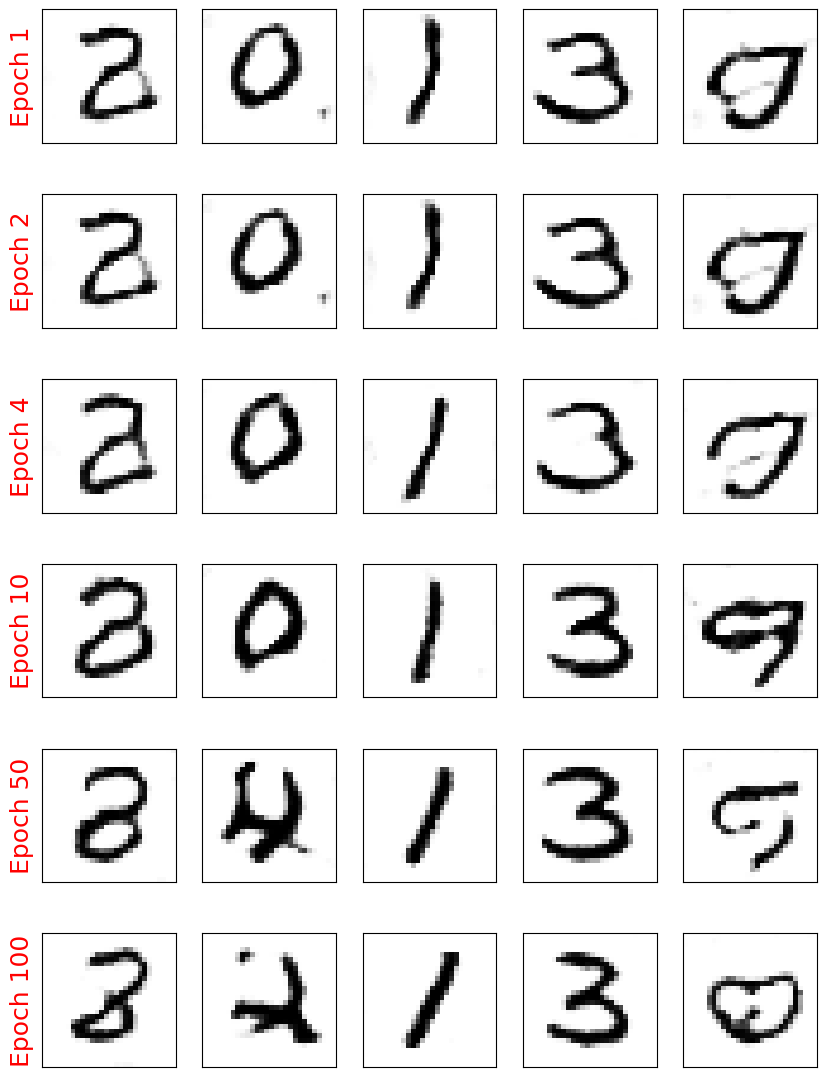

In [19]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

## Observation

The output quality of the DCGAN is much higher than that in problem 1.  The figures are much clearer and crisper than any of the models in problem 1.

Interestingly, the losses for the Discriminator in the DCGAN are much lower than those in Problem 1, and the losses for the Generator of the DCGAN are much higher than those in Problem 1.

# Problem 4

- Again, consider the attached notebook ch17_part2.ipynb. Keep MNIST (handwritten digits) dataset.
- In cell 22, in the definition of WGAN, replace recommended InstanceNorm2d layer with Batch normalization layer.
- Add a cell that would report on the Generator and the Discriminator loss and two outputs of the Discriminator.
- Again, test whether your code works with a small number of epochs before making a 100 epoch run.
- Report on the improvements or decrease of quality in network behavior and the quality of generated images.
- Make the comparison of losses of the discriminator and the generator with those obtained in the original notebook which was using InstanceNorm2d layers!

## Dissimilarity measures between two distributions

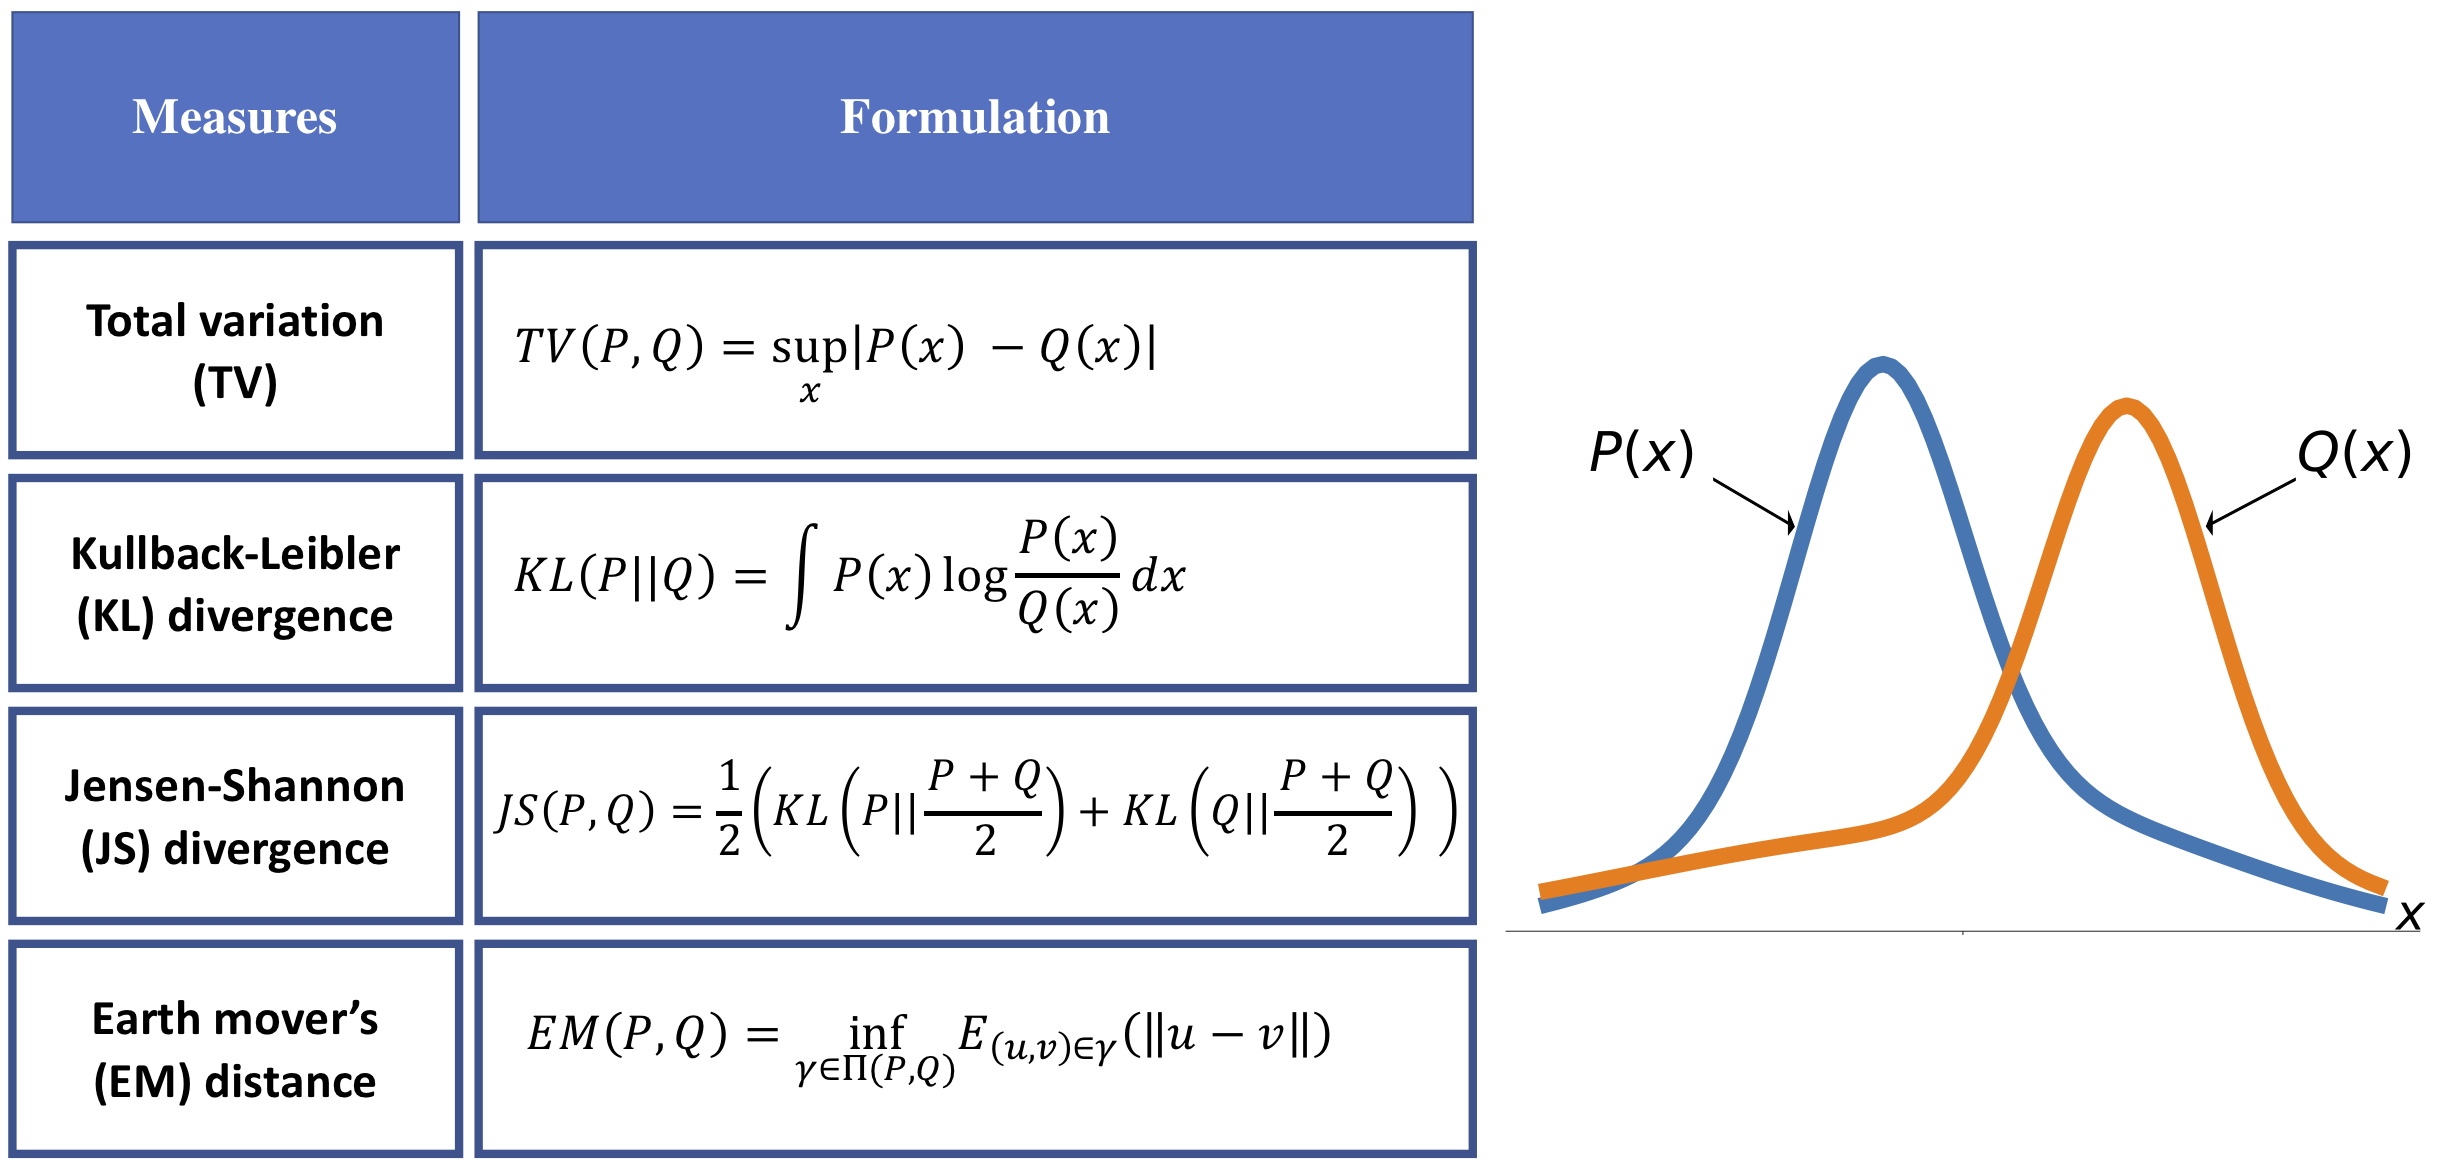

In [ ]:
Image(filename='figures/17_14.png', width=700)

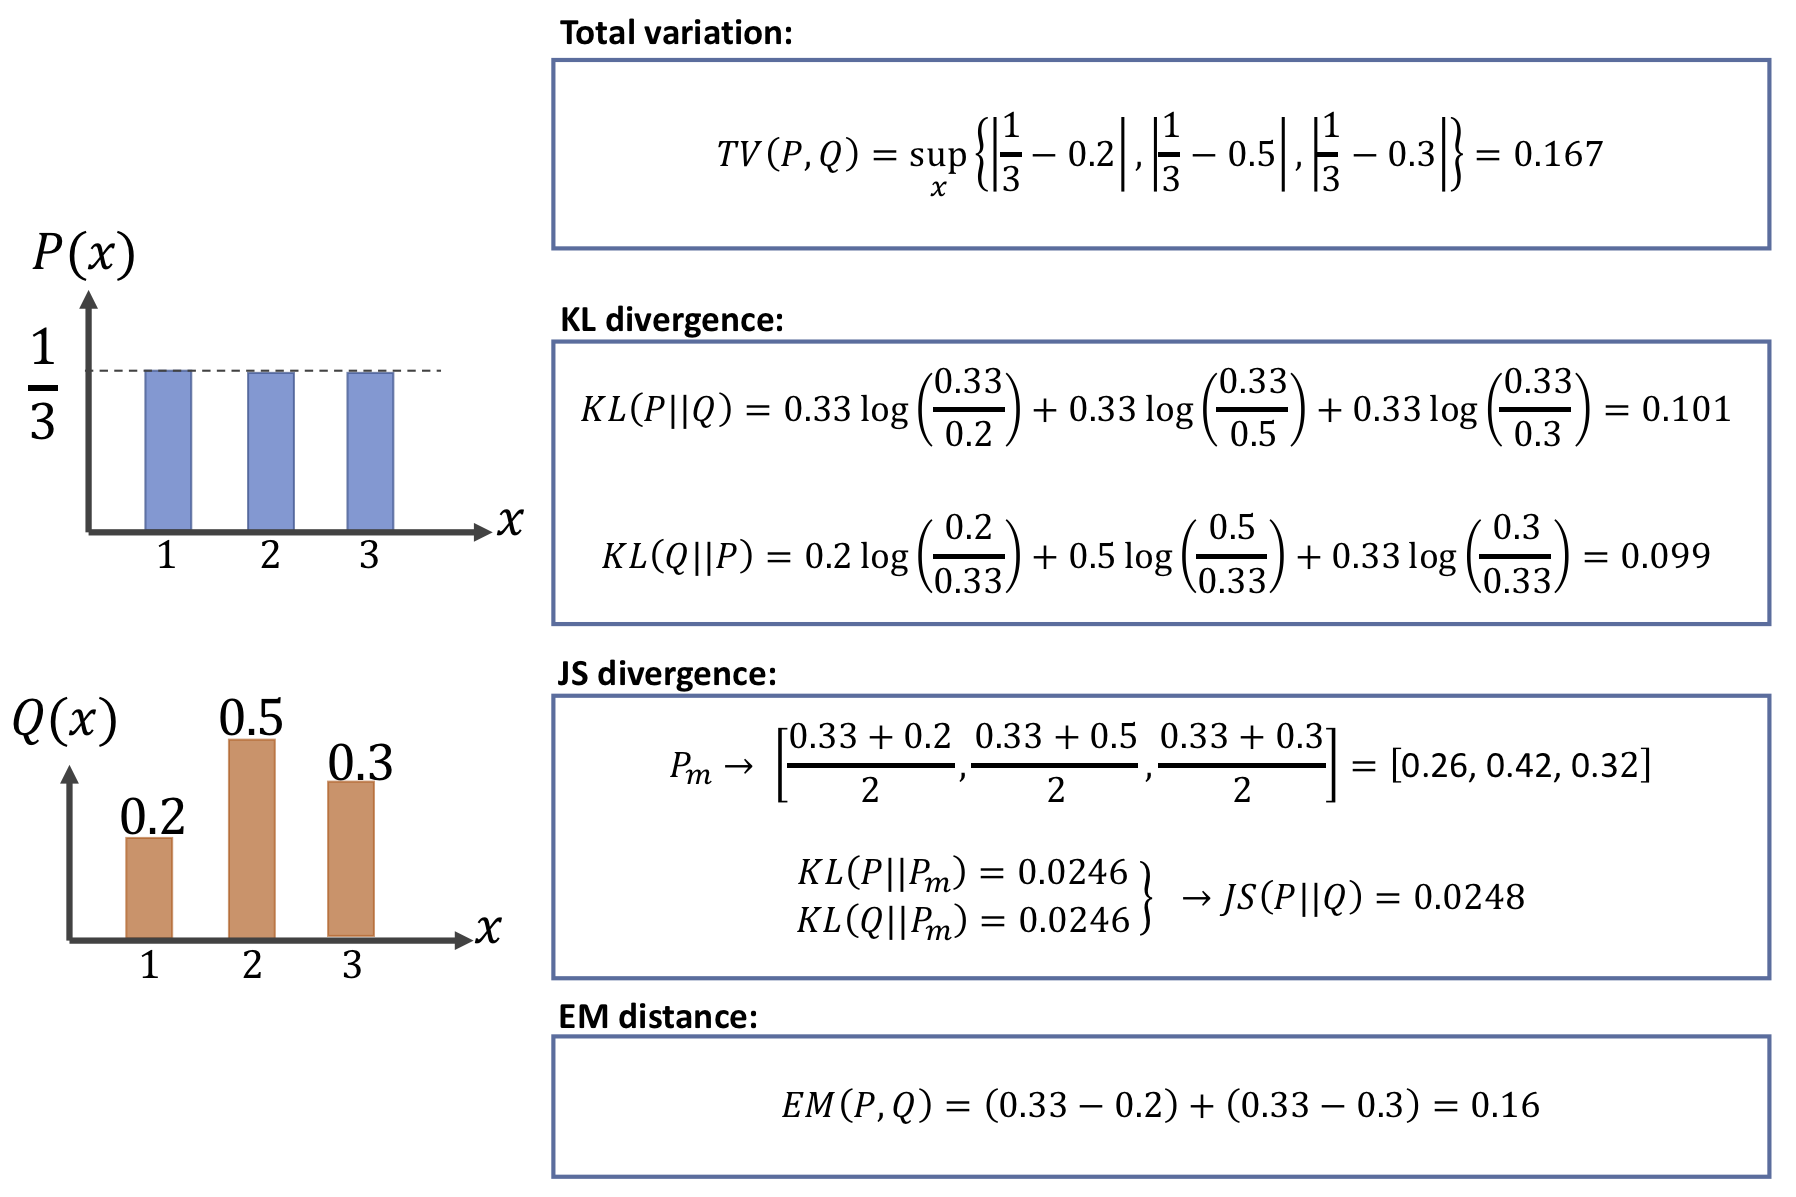

In [ ]:
Image(filename='figures/17_15.png', width=800)

## Using EM distance in practice for GANs

## Gradient penalty

## Implementing WGAN-GP to train the DCGAN model

In [40]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [41]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [42]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    # Calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()


In [43]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()

In [44]:
## Train the generator
def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [45]:
batch_size = 64
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

In [46]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())



Epoch 001 | D Loss >> -0.7539
Epoch 002 | D Loss >> -0.7998
Epoch 003 | D Loss >> -0.8268
Epoch 004 | D Loss >> -0.8172
Epoch 005 | D Loss >> -0.8153
Epoch 006 | D Loss >> -0.8172
Epoch 007 | D Loss >> -0.8262
Epoch 008 | D Loss >> -0.8241
Epoch 009 | D Loss >> -0.8210
Epoch 010 | D Loss >> -0.8214
Epoch 011 | D Loss >> -0.8127
Epoch 012 | D Loss >> -0.8206
Epoch 013 | D Loss >> -0.8299


KeyboardInterrupt: 

## Note: Due to issues with Google Colab, I have not been able to train for more than 12 epochs at a time without the runtime disconnecting, even after several attempts. I am using Colab Pro with V100 GPU.

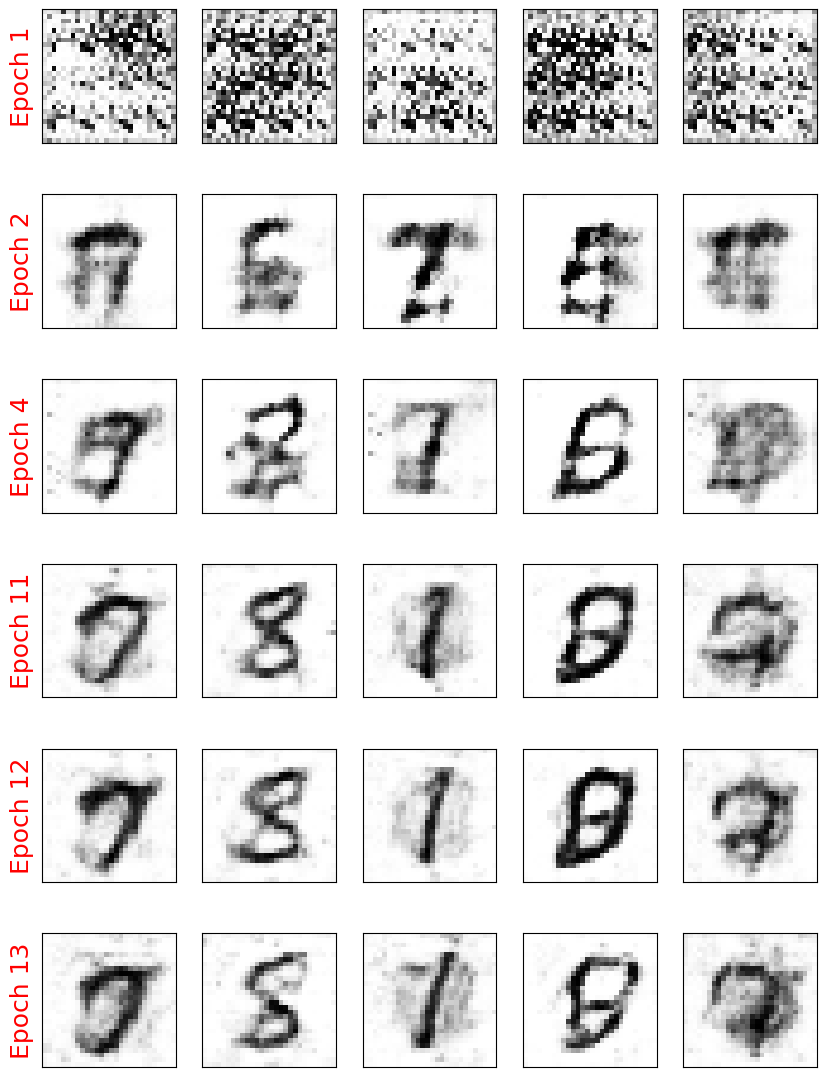

In [48]:
selected_epochs = [1, 2, 4, 11, 12, 13]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-wgan-gp-samples.pdf')
plt.show()


<br>
<br>

----

In [2]:
# ! python ../.convert_notebook_to_script.py --input ch17_part2.ipynb --output ch17_part2.py
!jupyter nbconvert --to html /Users/mpellegrin008/Documents/VS_Code/CSCI104_Advanced_DL/ch17_part2_Pellegrino_Matthew.ipynb

[NbConvertApp] Converting notebook /Users/mpellegrin008/Documents/VS_Code/CSCI104_Advanced_DL/ch17_part2_Pellegrino_Matthew.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1404223 bytes to /Users/mpellegrin008/Documents/VS_Code/CSCI104_Advanced_DL/ch17_part2_Pellegrino_Matthew.html
